# Statistical Learning - Linear Regression

---

## Contents

### [Simple Linear Regression](#simple)
   - [Estimating the Coefficients](#estimating-coefficients)
   - [Assessing the Accuracy of the Coefficient Estimates](#accuracy-coef)
   - [Assessing the Accuracy of the Model](#accuracy-model)
      - [Residual Standard Error](#rse)
      - [$R^2$ Statistic](#r2)
      
      
### [Multiple Linear Regression](#multiple)
   - [Estimating the Coefficients](#estimating-coefficients-mult)
   - [Assessing the Accuracy of the Coefficient Estimates](#accuracy-coef-mult)
   - [Variable Selection](#variable-selection)
   - [Assessing the Accuracy of the Model](#accuracy-model-mult)
   - [Predictions](#predictions)
   
   
### [Other Considerations in the Regression Model](#other)
   - [Qualitative Predictors](#qualitative-predictors)
   - [Extensions of the Linear Model](#extensions)
   - [Potential Problems](#potential-problems)
      - [Non-linearity](#non-linearity)
      - [Correlation of error terms](#correlation-error-terms)
      - [Heteroscedasticity](#heteroscedasticity)
      - [Outliers & High Leverage points](#outliers)
      - [Collinearity](#collinearity)
      
      
### [Comparison of Linear Regression with KNN](#comparison)


### [Lab](#lab)

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import seaborn as sns
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.set_printoptions(suppress=True)
%matplotlib inline
plt.style.use("fivethirtyeight")

---

## Utilities

In [2]:
def get_interval(model, x_test, method = "prediction", alpha = 0.05):
    intervals = model.get_prediction(x_test).summary_frame(alpha = alpha)
    del intervals["mean_se"]
    if method == "confidence":
        del intervals["obs_ci_lower"], intervals["obs_ci_upper"]
        intervals = intervals.rename(columns = {"mean": "mean_pred", "mean_ci_lower": "conf_int_lower",
                                                "mean_ci_upper": "conf_int_upper"})
    else:
        del intervals["mean_ci_lower"], intervals["mean_ci_upper"]
        intervals = intervals.rename(columns = {"mean": "mean_pred", "obs_ci_lower": "pred_int_lower",
                                                "obs_ci_upper": "pred_int_upper"})
    return intervals

In [3]:
def plot_residuals(model, figsize = (8, 4), ax = None):
    if not ax:
        fig, ax = plt.subplots(figsize = figsize)
    line_edge = [mpe.Stroke(linewidth = 8, foreground= "k"), mpe.Normal()]

    sns.residplot(x = model.fittedvalues, y = model.resid,
                  lowess = True, ax = ax,
                  line_kws={"color": "coral", "lw": 4, "path_effects": line_edge},
                  scatter_kws = {"facecolors": "cornflowerblue", "edgecolors": "k",
                                 "s": 100, "linewidth": 1.5})
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")
    plt.xlim(np.min(model.fittedvalues) - 1,
             np.max(model.fittedvalues) + 1)
    plt.show()

In [4]:
def plot_errors_corr(model, figsize = (8, 4), ax = None):
    if not ax:
        fig, ax = plt.subplots(figsize = figsize)
    line_edge = [mpe.Stroke(linewidth = 6, foreground= "k"), mpe.Normal()]
    ax.plot(model.resid.index, model.resid.values,
            linewidth = 1.5, path_effects = line_edge)
    ax.set_xlabel("Dataset Index")
    ax.set_ylabel("Residuals")
    plt.show()

In [5]:
def plot_stud_vs_leverage(model, p, n, figsize = (8, 4)):
    fig, ax = plt.subplots(figsize = figsize)
    studentized = model.get_influence().resid_studentized_internal
    leverage = model.get_influence().hat_matrix_diag
    avg_leverage = (p+1)/n
    sns.scatterplot(x = leverage, y = studentized,
                    ax = ax, s = 100, edgecolor = "k")
    plt.axvline(x = avg_leverage, linestyle = "--",
                linewidth = 1.5, color = "k")
    plt.axhline(y = 3, linestyle = "--", linewidth = 1.5, color = "k")
    plt.axhline(y = -3, linestyle = "--", linewidth = 1.5, color = "k")
    ax.set_xlabel("Leverage")
    ax.set_ylabel("Studentized Residuals")
    plt.show()

In [6]:
def plot_stud_vs_fitted(model, figsize = (8, 4)):
    fig, ax = plt.subplots(figsize = figsize)
    line_edge = [mpe.Stroke(linewidth = 8, foreground= "k"), mpe.Normal()]

    studentized = model.get_influence().resid_studentized_internal
    
    sns.residplot(x = model.fittedvalues, y = studentized,
                  lowess = True, ax = ax,
                  line_kws={"color": "coral", "lw": 4, "path_effects": line_edge},
                  scatter_kws = {"facecolors": "cornflowerblue", "edgecolors": "k",
                                 "s": 100, "linewidth": 1.5})
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Studentized Residuals")
    plt.xlim(np.min(model.fittedvalues) - 1,
             np.max(model.fittedvalues) + 1)
    plt.show()

In [7]:
def scale_location_plot(model, figsize = (8, 4)):
    fig, ax = plt.subplots(figsize = figsize)
    line_edge = [mpe.Stroke(linewidth = 8, foreground= "k"), mpe.Normal()]

    studentized = model.get_influence().resid_studentized_internal
    studentized = np.sqrt(np.abs(studentized))
    
    sns.residplot(x = model.fittedvalues, y = studentized,
                  lowess = True, ax = ax,
                  line_kws={"color": "coral", "lw": 4, "path_effects": line_edge},
                  scatter_kws = {"facecolors": "cornflowerblue", "edgecolors": "k",
                                 "s": 100, "linewidth": 1.5})
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Abs + Sqrt Studentized Residuals")
    plt.xlim(np.min(model.fittedvalues) - 1,
             np.max(model.fittedvalues) + 1)
    plt.show()

In [8]:
def probplot_residuals(model, figsize = (8, 4)):
    fig, ax = plt.subplots(figsize = figsize)
    studentized = model.get_influence().resid_studentized_internal
    stats.probplot(studentized, dist = "norm", plot = plt)
    plt.ylabel("Studentised Residuals")
    plt.xlabel("Normal Quantiles")
    plt.show()

In [9]:
def diagnostics_plots(model, p, n, figsize = (8, 4)):
    plot_residuals(model, figsize)
    probplot_residuals(model, figsize)
    plot_errors_corr(model, figsize)
    plot_stud_vs_fitted(model, figsize)
    scale_location_plot(model, figsize)
    plot_stud_vs_leverage(model, p, n, figsize)

In [10]:
def parse_interactions(cols, bad_vars):  
    interactions = list()
    feats = [col for col in auto.columns
             if col not in bad_vars]
    for i in range(0, len(feats)):
        for j in range(0, len(feats)):
            if feats[i] != feats[j]:
                interactions.append(f"{feats[i]}*{feats[j]}")
    return " + ".join(interactions)

---

## Datasets

_Ogni riga è un diverso mercato in cui i prodotti sono venduti; ogni colonna è il budget pubblicitario dedicato a un diverso mezzo di comunicazione. La response variable è Sales._

In [11]:
adv = pd.read_csv("data/advertising.csv", usecols = [1,2,3,4])
adv.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


_Ogni riga è un singolo individuo, con associate le proprie features. La response variable è Balance, cioè l'ipotetico debito collegato alla carta di credito._

In [12]:
cred = pd.read_csv("data/credit.csv", usecols = [1, 2, 3, 5, 6, 7, 9, 10, 11])
cred.head()

,Income,Limit,Rating,Age,Education,Gender,Married,Ethnicity,Balance
0,14.891,3606,283,34,11,Male,Yes,Caucasian,333
1,106.025,6645,483,82,15,Female,Yes,Asian,903
2,104.593,7075,514,71,11,Male,No,Asian,580
3,148.924,9504,681,36,11,Female,No,Asian,964
4,55.882,4897,357,68,16,Male,Yes,Caucasian,331


_Ogni riga è una diversa automobile, con associate le proprie features. Tipicamente la response variable è mpg._

In [13]:
auto = pd.read_csv("data/auto.csv", na_values = "?").dropna()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


---

<a id="simple"></a>
# Simple Linear Regression

La regressione lineare univariata è un *learning method* che prova a predire una *response* quantitativa $Y$ utilizzando un singolo predittore $X$.

L'assunzione di fondo è che $X$ e $Y$ siano legati da una relazione lineare, modellata come segue:

$$\large Y\approx \beta_0+\beta_1X$$

$\beta_0$ e $\beta_1$ sono due costanti sconosciute chiamate rispettivamente **intercept** e **slope** del modello lineare. Più in generale, $\beta_0$ e $\beta_1$ prendono il nome di **model coefficients** o **model parameters**.

---

<a id="estimating-coefficients"></a>
## Estimating the Coefficients

I coefficienti $\beta_0$ e $\beta_1$ sono sconosciuti, e per utilizzare il modello lineare è necessario crearne una stima a partire dal *training set*.

Il metodo più comune per farlo è il **Least Squares Criterion**.

Se $\hat{y}_i=\hat{\beta}_0+\hat{\beta}_1x_i$ è la *prediction* della *response* per l'osservazione $x_i$, il suo **residual** $e_i=y_i-\hat{y}_i$ è la differenza fra tale *prediction* e la corrispondente *observed response*.

Definiamo la **Residual Sum of Squares** come la somma dei quadrati dei residui di tutte le istanze del *training set*.

$$\large RSS=e_1^2+e_2^2+\dots+e_n^2$$

$$RSS=\left(y_1-\hat{\beta}_0+\hat{\beta}_1x_1\right)^2+
\left(y_2-\hat{\beta}_0+\hat{\beta}_1x_2\right)^2+\dots+
\left(y_n-\hat{\beta}_0+\hat{\beta}_1x_n\right)^2$$

Il *Least Squares Criterion* costruisce delle stime di $\beta_0$ e $\beta_1$ scegliendo quei valori che minimizzano la *RSS*.

E' possibile dimostrare che, per la regressione lineare univariata, i valori che minimizzano la *RSS* sono:

$$\large \hat{\beta}_1=\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}
{\sum_{i=1}^{n}(x_i-\bar{x})^2}$$

$$\large \hat{\beta}_0=\bar{y}-\hat{\beta}_1\bar{x}$$

I due valori $\hat{\beta}_0$ e $\hat{\beta}_1$ sono formalmente definiti come le **Least Squares Coefficient Estimates** della regressione lineare univariata, e il modello lineare che costituiscono insieme prende il nome di **Least Squares Line**.

---

<a id="accuracy-coef"></a>
## Assessing the Accuracy of the Coefficient Estimates

Sappiamo che la generica relazione fra *predictor* e *response* va sempre espressa nella forma $Y=f(X)+\epsilon$, dove $\epsilon$ è un *error term* indipendente da $X$ e a media nulla.

Se la *systematic information* dev'essere approssimata con un modello lineare, allora la relazione fra $X$ e $Y$ può essere formulata in questo modo:

$$\large Y=\beta_0+\beta_1X+\epsilon$$

Questo modello è definito formalmente come **Population Regression Line**, e rappresenta la *migliore* approssimazione lineare della relazione fra $X$ e $Y$.

L'**intercept** $\beta_0$ è l'*expected value* di $Y$ nel momento in cui $X$ è nullo, mentre la **slope** $\beta_1$ rappresenta l'incremento o decremento medio subito da $Y$ in risposta ad un incremento unitario di $X$.

L'**error term**, invece, raccoglie tutto ciò che non stiamo includendo nel modello lineare, come ad esempio: la possibilità che la relazione fra $X$ e $Y$ non sia realmente lineare, variabili non tracciate nel dataset o addirittura errori di misurazione.

Chiaramente la *population regression line* è sempre sconosciuta, ma è stato dimostrato che le stime $\hat{\beta}_0$ e $\hat{\beta}_1$ prodotte attraverso il *least squares criterion* sono degli **unbiased estimator** dei *population parameters* $\beta_0$ e $\beta_1$.

Ciò vuol dire che, usando un determinato *training set*, le stime potrebbero sovrastimare i valori dei *parameters*, mentre invece usando un altro *training set* gli stessi *parameters* potrebbero essere sottostimati. In generale, però, calcolando una media delle stime ottenute su un gran numero di dataset, otterremmo una stima perfetta!

In altre parole, la media di una serie di *unbiased estimations* è estremamente vicina al valore del *population parameter* oggetto della stima. Ma non abbiamo praticamente mai la possibilità di costruire stime molteplici dei coefficienti del modello lineare: spesso dobbiamo accontentarci di un solo *training set*, cioè di un solo *sample*.

Una domanda sorge spontanea: quanto accurata è la stima parametrica prodotta da un singolo dataset? La risposta va trovata nel calcolo dello **standard error**, che rappresenta la deviazione media delle stime $\hat{\beta}_0$ e $\hat{\beta}_1$ rispetto ai *population parameters*.

Le formule per il calcolo degli *standard error* dei *least squares coefficients* sono espresse più comunemente sotto forma del loro quadrato:

$$\large SE(\hat{\beta}_0)^2=\sigma^2\left[
\frac{1}{n}+\frac{\bar{x}^2}{\sum_{i=1}^{n}(x_i-\bar{x})^2}\right]$$

$$\large SE(\hat{\beta}_1)^2=\frac{\sigma^2}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$$

L'accuratezza delle stime, quindi, dipende da due componenti principali: le osservazioni del *training set* (nello specifico la numerosità del *training set*, la media del predittore e le deviazioni quadrate rispetto alla media del predittore), e $\sigma^2$, che rappresenta la **varianza dell'*error term* $\epsilon$**, che caratterizza l'equazione della *population regression line*.

$$\large \sigma^2=Var(\epsilon)$$

Affinché queste formule siano valide, c'è un'assunzione da fare: gli *error term* $\epsilon_i$ associati a ciascuna osservazione **non devono essere correlati** fra di loro e devono condividere la **stessa varianza** $\sigma^2$. Quest'assunzione è chiaramente non verificata nella realtà, ma le formule presentate si rivelano comunque una buona approssimazione.

Nella realtà l'*error term* è sconosciuto, così come lo è la sua varianza. E' stato dimostrato che una stima di $\sigma$, cioè la deviazione standard dell'*error term* $\epsilon$, può essere calcolata a partire dai dati attraverso il calcolo del **Residual Standard Error**, che nella regressione lineare univariata può essere calcolato come segue:

$$\large RSE=\sqrt{\frac{1}{n-2}RSS}=\sqrt{\frac{1}{n-2}\sum_{i=1}^{n}
(y_i-\hat{y}_i)^2}$$

E' proprio grazie a questa stima di $\sigma$ che siamo in grado di calcolare gli *standard error* e quindi di produrre una misura dell'accuratezza dei coefficienti del modello. Per farlo, utilizziamo dei **Confidence Intervals**.

Ad esempio, c'è approssimativamente una probabilità del 95% che i valori dei *population parameters* siano contenuti nei seguenti intervalli:

$$\large \left[\hat{\beta}_1-t_{df}^*SE(\hat{\beta}_1),\;\;
\hat{\beta}_1+t_{df}^*SE(\hat{\beta}_1)\right]$$

$$\large \left[\hat{\beta}_0-t_{df}^*SE(\hat{\beta}_0),\;\;
\hat{\beta}_0+t_{df}^*SE(\hat{\beta}_0)\right]$$

In questo caso, il *critical t-score* è il *97.5-quantile* di una *t-distribution* con $n-2$ *degrees of freedom*.

Ad esempio, lavorando sul dataset *Advertising*, possiamo notare come in associazione alle stime parametriche ci siano anche gli estremi dei corrispondenti *95% confidence interval*.

In [14]:
model = smf.ols("Sales ~ TV", adv).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


Guardando i risultati possiamo affermare che, in assenza di budget dedicato alla *TV*, le vendite in media si assesteranno fra le 6130 e le 7940 unità. Inoltre, per ogni 1000$ di incremento di budget per la *TV*, ci aspettiamo un incremento medio di vendite fra le 42 e le 53 unità.

<br>

Un altro step fondamentale per i modelli di regressione lineare è verificare che i risultati ottenuti nel processo di *estimation* siano statisticamente significativi.

Possiamo farlo con un **Hypothesis Test** impostato in modo che l'ipotesi nulla sia _"Non c'è alcuna relazione fra X e Y"_ e l'ipotesi alternativa sia _"Esiste una qualche relazione fra X e Y"_.

Ciò si traduce matematicamente nelle seguenti formulazioni:

$$\large H_0: \beta_1=0$$

$$\large H_A:\beta_1 \neq 0$$

Difatti, se $\beta_1$ = 0, avremmo una *population regression line* che si riduce a $Y=\beta_0+\epsilon$, e quindi $X$ e $Y$ non sarebbero realmente associati.

All'atto pratico, il test si concretizza nel calcolo di una *t-statistic* come *test statistic*, utilizzando $n-2$ *degrees of freedom*:

$$\large t=\frac{\hat{\beta}_1-0}{SE(\hat{\beta}_1)}$$

La stima della *slope* $\hat{\beta}_1$ funge da *point estimate* per $\beta_1$, e il nostro obiettivo è determinare se tale stima sia sufficientemente lontana da zero da essere sicuri che il corrispondente *population parameter* non sia nullo. Il tutto dipende dal grado di accuratezza della stima $\hat{\beta}_1$, e quindi dal suo *standard error*: se questo è piccolo, potremmo essere in grado di rigettare l'ipotesi nulla anche per valori di $\hat{\beta}_1$ vicini a zero; se invece è particolarmente grande, è necessario che la stima sia molto distante da zero.

Possiamo calcolare il *p-value* del test come l'area sottesa ad una *t-distribution* con $df=n-2$ alla destra di $t$ e alla sinistra di $-t$, trattandosi di un *two-sided test*.

Nel modello che associa *TV* a *Sales*, notiamo dei *p-values* nulli, pertanto possiamo concludere con certezza che i parametri della *population regression line* non saranno nulli, e che quindi esista realmente una relazione fra *TV* e *Sales*.

In [15]:
model = smf.ols("Sales ~ TV", adv).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


---

<a id="accuracy-model"></a>
## Assessing the Accuracy of the Model

Per quantificare il grado di *fitting* ai dati di *training* di un modello di regressione lineare, possiamo utilizzare due metriche: il *residual standard error* e l'$R^2$.

<a id="rse"></a>
### Residual Standard Error

Abbiamo evidenziato come, nella generica relazione fra $X$ e $Y$, ogni osservazione è associata ad un *error term* $\epsilon_i$. A causa della presenza di questi errori, anche se conoscessimo i parametri della vera *regression line* $\beta_0$ e $\beta_1$, non saremmo mai in grado di predire perfettamente $Y$ a partire da $X$.

Il **Residual Standard Error** rappresenta una stima della deviazione standard dell'*error term* $\epsilon$.

In parole povere, si tratta della deviazione media che i valori della *response* assumono rispetto alla *population regression line*, che ricordiamo essere soltanto la *migliore* modellazione lineare della relazione fra $X$ e $Y$, e non l'equazione che descrive tutti i valori assunti realmente dalla *response*.

$$\large RSE=\sqrt{\frac{1}{n-2}RSS}=\sqrt{\frac{1}{n-2}\sum_{i=1}^{n}
(y_i-\hat{y}_i)^2}$$

Nel modello *TV - Sales*, ad esempio, il *RSE* è $3.26$.

In [16]:
def rse_sm(model):
    return np.sqrt(model.ssr / model.df_resid)

In [17]:
model = smf.ols("Sales ~ TV", adv).fit()

rse_sm(model)

3.258656368650463

Ciò vuol dire che le vendite reali, in ogni mercato, deviano in media dalla *true regression line* di circa 3260 unità.

Un altro modo di interpretare il risultato è il seguente: se conoscessimo con esattezza i valori dei *population parameters*, una qualsiasi *prediction* di vendite basata su *TV* sarebbe sbagliata **in media** di 3260 unità. 

Chiaramente questa differenza media di 3260 unità può essere accettabile o meno in base al contesto. Ad esempio, dato che il valore medio di *Sales* su tutti mercati è di 14.000 unità, possiamo affermare che il **percentage error** descritto dal *RSE* è di $3260/14000=23\%$.

Il *RSE* rappresenta una misura del **Lack of Fit** del modello ai dati. Se le *predictions* ottenute dal modello sono molto vicine alle corrispondenti *observed responses*, il *RSE* sarà piccolo e potremo affermare che il modello ha *fittato* molto bene i dati a disposizione. Al contrario, con grandi differenza fra $\hat{y}_i$ e $y_i$, il *RSE* sarà maggiore e ci costringerà ad a dichiarare il modello non adatto a fittare il *training set*.

<br>

<a id="r2"></a>
### $R^2$ Statistic

L'$R^2$ è un'altra misura del *lack of fit* di un modello lineare, ma al contrario del *RSE* ha il vantaggio di essere una metrica *unitless*, cioè risulta indipendente dai valori di $Y$. Tale indipendenza è dovuta al fatto che $R^2$ è definita come una proporzione, quindi assume solo valori nell'intervallo $[0, 1]$.

$$\large R^2=\frac{TSS-RSS}{TSS}=1-\frac{RSS}{TSS}$$

*TSS* è la **Total Sum of Squares**, e rappresenta la variabilità totale nella *response* prima dell'applicazione della regressione.

$$\large TSS=\sum_{i=1}^{n}(y_i-\bar{y})^2$$

Al contrario, la *RSS* è la variabilità rimasta **unexplained** dopo l'applicazione della regressione.

Di conseguenza, la differenza $TSS-RSS$ coincide con la variabilità nella *response* che è stata spiegata (**explained**) o rimossa dalla regressione.

L'$R^2$, quindi, è la proporzione di variabilità di $Y$ che può essere spiegata utilizzando $X$.

Se $R^2$ è vicino a uno, quasi tutta la variabilità della *response* è spiegata dalla regressione; se invece è vicino a zero, non molta della variabilità di $Y$ è spiegabile tramite $X$, e ciò può accadere perché il modello lineare è sbagliato o perché la varianza dell'*error term* $\sigma^2$ è particolarmente elevata.

Nel modello *TV - Sales*, ad esempio, $R^2$ vale 0.61, quindi possiamo affermare che quasi i due terzi della variabilità di *Sales* possono essere spiegati da una regressione lineare basata su *TV*.

In [18]:
model = smf.ols("Sales ~ TV", adv).fit()

model.rsquared

0.611875050850071

Per com'è definita, la $R^2$ *statistic* rappresenta anche una misura dell'entità della relazione lineare esistente fra $X$ e $Y$, cioè assume lo stesso ruolo della *correlation statistic*.

E' stato dimostrato che, nella regressione lineare univariata, l'$R^2$ coincide proprio con il quadrato della *correlation* fra $X$ e $Y$.

$$\large R^2=Cor(X,Y)^2$$

$$\large \frac{TSS-RSS}{TSS}=\left(
\frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}
{\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
\right)^2$$

---

<a id="multiple"></a>
# Multiple Linear Regression

Nei problemi reali è molto raro avere a  un solo predittore con cui modellare l'andamento della variabile *response*. Sorge spontanea la domanda: come possiamo estendere le analisi della *simple linear regression* per sfruttare tutti i predittori a disposizione?

L'opzione più intuitiva, cioè costruire $p$ regressioni lineari univariate distinte, una per ognuno dei $p$ *predictors*, è in realtà la più sbagliata. Innanzitutto, non è chiaro in che modo si dovrebbero combinare le *prediction* di $p$ regressioni diverse per fornire un risultato unico. Inoltre, ciascuno dei modelli non tiene conto dell'esistenza degli altri *predictor* e della correlazione fra gli stessi, di conseguenza anche le singole stime parametriche sarebbero inaffidabili.

La regressione lineare mutivariata risolve il problema assegnando a ciascun *predictor* una propria *slope*, ed estendendo il modello lineare descritto nella versione univariata:

$$\large Y=\beta_0+\beta_1X_1+\beta_2X_2+\dots+\beta_pX_p+\epsilon$$

La generica *slope* $\beta_i$ va interpretata come l'incremento o decremento medio che la *response* riceve in risposta ad un incremento unitario del *predictor* corrispondente $X_i$ e mantenendo costanti i valori di tutti gli altri predittori.

---

<a id="estimating-coefficients-mult"></a>
## Estimating the Coefficients

Le stime dei *population parameters* possono essere ricavate sfruttando ancora una volta il **Least Square Criterion**, cioè individuando quei valori dei parametri $\beta_i$ che minimizzano la *RSS*.

$$\large RSS=\sum_{i=1}^{n}\left(y_i-\hat{\beta}_0-\hat{\beta}_1x_{i1}
-\hat{\beta}_2x_{i2}-\dots-\hat{\beta}_px_{ip}\right)^2$$

Applichiamo, ad esempio, la regressione multipla per predire *Sales* usando il budget di tutti i mezzi di comunicazione.

In [19]:
model = smf.ols("Sales ~ TV + Radio + Newspaper", adv).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


Notiamo che per una certa quantità di budget *TV* e *Newspaper*, spendere 1000\$ in più sulla *Radio* porta ad un incremento delle vendite di circa 189 unità.

Osserviamo, inoltre, che *Newspaper* non è un predittore significativo di *Sales*, in quanto il suo *p-value* supera il *significance level* di default, cioè $0.05$.

Proviamo a modellare *Sales* usando solo *Newspaper*:

In [20]:
model = smf.ols("Sales ~ Newspaper", adv).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


Al contrario di quanto dichiarato nel modello multiplo, nlla regressione lineare univariata *Newspaper* sembra essere un *predictor* significativo di *Sales*! La soluzione di questo paradosso va trovata nella matrice di correlazione che collega i tre *predictors*.

In [21]:
adv[["TV", "Newspaper", "Radio"]].corr()

,TV,Newspaper,Radio
TV,1.000000,0.056648,0.054809
Newspaper,0.056648,1.000000,0.354104
Radio,0.054809,0.354104,1.000000


Notiamo come la correlazione fra *Radio* e *Newspaper* sia 0.35. Ciò indica una tendenza ad investire più budget in *Newspaper* nei mercati in cui si investe di più in *Radio*, e viceversa.

Guardando ora il modello di regressione multipla, possiamo affermare che nei mercati in cui si investe di più in *Radio* si hanno più vendite, e che in questi stessi mercati, come riporta la matrice di correlazione, si investe di più anche in *Newspaper*.

In definitiva, nel modello univariato osserviamo una forte associazione fra alti valori di *Sales* ed alti valori di *Newspaper*, anche se quest'ultimo non rappresenta il vero mezzo di comunicazione che guida l'aumento delle vendite. A causa della correlazione fra di essi, *Newspaper* gode dell'effetto di *Radio* su *Sales*.

---

<a id="accuracy-coef-mult"></a>
## Assessing the Accuracy of the Coefficient Estimates

Per verificare se i risultati del *least squares criterion* siano statisticamente significativi, dobbiamo nuovamente utilizzare l'*hypothesis testing*. L'ipotesi nulla e l'ipotesi alternativa vanno formulate come segue:

$$\large H_0:\beta_1=\beta_2=\dots=\beta_p=0$$

$$\large H_A: \text{at least one } \beta_j \text{ is non-zero}$$

La *test statistic* di riferimento è una *F-statistic*:

$$\large F=\frac{(TSS-RSS)/p}{RSS/(n-p-1)}$$

E' possibile dimostrare che, nel momento in cui non c'è alcuna relazione fra *response* e *predictors*, l'*F-statistic* assume valori vicini ad uno. Al contrario, se l'ipotesi nulla è verificata, l'*F-statistic* assume valori superiori ad uno.

Ad esempio, nel modello di regressione multipla calcolato sui dati di *Advertising*, notiamo un *F-statistic* pari a 570 ed un *p-value* praticamente nullo. Ciò indica che almeno uno dei media è correlato con *Sales*.

In [22]:
model = smf.ols("Sales ~ TV + Radio + Newspaper", adv).fit()
model.summary().tables[0]

Dep. Variable:,Sales,R-squared:,0.897
Model:,OLS,Adj. R-squared:,0.896
Method:,Least Squares,F-statistic:,570.3
Date:,"Sun, 21 Feb 2021",Prob (F-statistic):,1.58e-96
Time:,08:49:39,Log-Likelihood:,-386.18
No. Observations:,200,AIC:,780.4
Df Residuals:,196,BIC:,793.6
Df Model:,3,,
Covariance Type:,nonrobust,,


In [23]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


Inoltre, è stato dimostrato come il quadrato delle singole *t-statistic* associate a ciascun predittore nel *report* del modello lineare corrispondano al valore dell'*F-statistic* che otterremmo se costruissimo il modello senza quella specifica variabile, includendo tutti gli altri predittori. E' come se, nella regressione multipla, le *t-statistic* descrivano una sorta di **partial effect** dell'inclusione di tale variabile nel modello.

E' bene specificare, però, che per dimostrare l'esistenza di una relazione fra *response* e *predictors* non è sufficiente guardare solo i *p-values* dei singoli predittori, assicurandosi che almeno uno di essi sia statisticamente significativo.

Questo perché, ad esempio, per un problema in cui ci sono 100 *predictors*, circa il 5% dei corrispondenti 100 *p-values* assumeranno valore inferiore a 0.05 per puro caso, anche se non c'è una vera relazione fra predittori e *response*.

L'*F-statistic* non soffre di questo problema perché è configurata per gestire contemporaneamente più predittori, quindi se l'ipotesi nulla è vera, c'è solo un 5% di probabilità che il suo valore sarà sotto il *significance level* per puro caso, a prescindere dal numero di variabili coinvolte.

---

<a id="variable-selection"></a>
## Variable Selection

Supponendo che l'*F-statistic* ed il relativo *p-value* suggeriscano che esista una relazione fra *response* e *predictors*, resta da capire quali predittori siano realmente associati alla *response* e quali no.

Rispondere a questa domanda controllando le singole *t-statistics* e i corrispondenti *p-value* è l'approccio sbagliato; bisogna impostare un processo di **Variable Selection**.

All'atto pratico, si tratta dell'addestramento sequenziale di modelli diversi, ognuno caratterizzato da un diverso sottoinsieme di predittori, alla ricerca della miglior combinazione possibile.

Esistono diverse statistiche per confrontare questi modelli tra loro, come il *Mallow's Cp*, l'*Akaike Information Criterion* (*AIC*), il *Bayesian Information Criterion* (*BIC*) e l'*Adjusted $R^2$*.

Il problema è che, con $p$ predittori a disposizione, abbiamo $2^p$ possibili combinazioni di modelli, e utilizzare le statistiche appena descritte per confrontarli tutti è impraticabile.

Per risolvere il problema, abbiamo tre approcci principali:
- **Forward Selection**: si inizia con il *null model*, cioè un modello che contiene un'*intercept* e nessun predittore; si addestrano poi $p$ regressioni lineari univariate e si aggiunge al *null model* la variabile che presenta il *RSS* più basso; si prosegue il ciclo andando alla ricerca del predittore che costituisce il modello a due variabili con la più bassa *RSS*, e così via.


- **Backward Selection**: si inizia con un modello che contiene tutti i predittori, e si rimuove la variabile associata al *p-value* più grande, cioè la meno significativa; si addestra un nuovo modello con i restanti $p-1$ predittori, rimuovendo la nuova variabile meno significativa; il processo si ripete fin quando tutti i predittori rimasti non presentano un *p-value* al di sotto una certa *threshold*.


- **Mixed Selection**: si inizia con il *null model* ed una *forward selection* classica, avendo cura però di tenere d'occhio i *p-values* ad ogni iterazione; se, ad un certo punto, uno di essi supera una certa soglia, si rimuove la corrispondente *feature* dal modello. Si continua con questa alternanza fra *forward* e *backward steps* fin quando non si verificano due condizioni: tutte le variabili incluse nel modello presentano un *p-value* sotto soglia e, allo stesso tempo, ci si assicura che tutte le variabili non incluse presenterebbero un *p-value* sopra soglia.

---

<a id="accuracy-model-mult"></a>
## Assessing the Accuracy of the Model

Due delle metriche più utilizzate per quantificare la qualità del *fitting* ai dati di *training* da parte dei modelli sono il *RSE* e l'$R^2$.

Se nella regressione lineare univariata $R^2$ coincide con il quadrato della correlazione fra *response* e *predictor*, nella regressione multipla esso equivale al quadrato della correlazione fra l'*observed response* e la *predicted response*.

$$\large R^2=Cor(Y,\hat{Y})^2$$

$$\large \frac{TSS-RSS}{TSS}=\left(
\frac{\sum_{i=1}^{n}(y_i-\bar{y})(\hat{y}_i-\bar{\hat{y}})}
{\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}\sqrt{\sum_{i=1}^{n}(\hat{y}_i-\bar{\hat{y}})^2}}
\right)^2$$

Possiamo osservare come il modello che include tutti i mezzi di comunicazione abbia $R^2$ superiore rispetto al modello con solo *TV + Radio*, nonostante sia stato dimostrato che *Newspaper* non rappresenta un predittore significativo per *Sales*.

In [24]:
model = smf.ols("Sales ~ TV", adv).fit()
model.rsquared

0.611875050850071

In [25]:
model = smf.ols("Sales ~ TV + Radio", adv).fit()
model.rsquared

0.8971942610828956

In [26]:
model = smf.ols("Sales ~ TV + Radio + Newspaper", adv).fit()
model.rsquared

0.8972106381789522

In realtà l'$R^2$ non può che aumentare quando si aggiungono nuovi predittori al modello, anche se debolmente associati con la *response*. Ciò è dovuto al fatto che l'aggiunta di una variabile nelle equazioni del *least squares criterion* permette al *learning algorithm* di fittare il *training set* con maggiora accuratezza.

D'altro canto, nel momento in cui la differenza fra i due $R^2$ è minima, non è che un'ulteriore conferma che tale predittore può anche non essere incluso nel modello. Al contrario, passando da un modello con solo *TV* al modello con *TV + Radio*, notiamo un incremento considerevole di $R^2$.

<br>

Il **Residual Standard Error**, per la regressione multivariata, si calcola come nel caso semplice a meno di una correzione dei *degrees of freedom*.

$$\large RSE=\sqrt{\frac{1}{n-p-1}RSS}$$

Si nota subito la differenza di *RSE* fra il modello univariato e il modello con *TV + Radio*, a testimonianza del fatto che *Radio* è un buon predittore di *Sales*.

Aggiungendo *Newspaper*, invece, il *RSE* addirittura aumenta! Sappiamo che con l'aggiunta di una nuova variabile la *RSS* diminuisce, ma se tale decrescita non compensa l'aumento di valore del denominatore $n-p-1$, allora la metrica generale tende ad aumentare, evidenziando come il predittore aggiunto non sia adatto alla previsione della *response*.

In [27]:
def rse_sm(model):
    return np.sqrt(model.ssr / model.df_resid)

In [28]:
model = smf.ols("Sales ~ TV", adv).fit()
rse_sm(model)

3.258656368650463

In [29]:
model = smf.ols("Sales ~ TV + Radio", adv).fit()
rse_sm(model)

1.681360912508001

In [30]:
model = smf.ols("Sales ~ TV + Radio + Newspaper", adv).fit()
rse_sm(model)

1.685510373414744

---

<a id="predictions"></a>
## Predictions

Date le stime parametriche $\hat{\beta}_i$ ottenute con il *least squares criterion*, possiamo utilizzarle in combinazione a delle osservazioni di test per realizzare delle *predictions* della *response*.

$$\large \hat{y}=\hat{\beta}_0+\hat{\beta}_1x_1+\dots+\hat{\beta}_px_p$$

Specifichiamo che ci sono tre tipi di *incertezza* associati a queste *predictions*.

Innanzitutto il *least squares plane* è solo una stima del *population regression plane*, quindi dobbiamo tener conto del **reducible error**.

$$\large \hat{Y}=\hat{\beta}_0+\hat{\beta}_1X_1+\dots+\hat{\beta}_pX_p$$

$$\large Y=f(X)+\epsilon \;\;\; \rightarrow \;\;\; f(X)=\beta_0+\beta_1X_1+\dots+\beta_pX_p$$

Per quantificare l'entità del *reducible error*, cioè la differenza fra $\hat{Y}$ ed $f(X)$, possiamo utilizzare i *confidence intervals*.

In secondo luogo, dobbiamo sempre ricordare che l'assunzione lineare di fondo è quasi sicuramente un'approssimazione della realtà, pertanto c'è un'ulteriore sorgente di *reducible error* da tenere in considerazione: il **model bias**.

Infine, anche se conoscessimo con precisione l'andamento della *systematic information*, la *response* non potrebbe mai essere predetta correttamente a causa della presenza dell'*error term* $\epsilon$, cioè dell'**irreducible error**.

Per quantificare l'entità dell'*irreducible error*, cioè la differenza fra l'*observed response* $Y$ e la *predicted response* $\hat{Y}$, possiamo usare i *prediction intervals*.

I **prediction intervals** sono intervalli la cui estensione è sempre superiore a quella dei *confidence intervals*, in quanto incorporano sia l'errore nella stima di $f(X)$ (il *reducible error*) sia l'incertezza relativa a quanto la *response* di un determinato *data point* possa differire dal *population regression plane* (l'*irreducible error*).

Facciamo degli esempi:

In [31]:
model = smf.ols("Sales ~ TV + Radio", adv).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9211,0.294,9.919,0.000,2.340,3.502
TV,0.0458,0.001,32.909,0.000,0.043,0.048
Radio,0.1880,0.008,23.382,0.000,0.172,0.204


I *confidence intervals* sono utilizzati per quantificare l'incertezza legata alla *response* media dell'intero dataset.

Ad esempio, se 100K\$ sono spesi in *TV* e 20K\$ in *Radio*, il *95% CI* è pari a $[10.98, 11.52]$. Possiamo interpretare questo risultato come segue: se raccogliessimo un gran numero di dataset simili ad *Advertising* e costruissimo per ognuno di essi un *95% CI* incentrato sul valore medio di *Sales* dati 100K\$ investiti in *TV* e 20K\$ in *Radio*, il 95% di questi intervalli conterrebbe certamente il vero valore medio di *Sales*.

In [32]:
x_test = pd.DataFrame({"TV": [100], "Radio": [20]})

get_interval(model = model, x_test = x_test, method = "confidence")

,mean_pred,conf_int_lower,conf_int_upper
0,11.256466,10.985254,11.527677


Un *prediction interval*, invece, può essere utilizzato per quantificare l'incertezza sulla *prediction* di *Sales* relativamente ad una singola osservazione.

Assegnano sempre 100K\$ in *TV* e 20K\$ in *Radio*, il corrispondente *95% prediction interval* sarebbe $[7.93, 14.58]$. Possiamo interpretare questo risultato come segue: il 95% degli intervalli costruiti in questo modo, cioè raccogliendo diversi dataset e costruendo per ognuno un *95% PI*, conterrebbero sicuramente il vero valore della *response* per un mercato in cui si spendono 100K\$ per la *TV* e 20K\$ per la *Radio*.

Entrambi i tipi di intervalli sono incentrati su $11.25$, ma il *prediction interval* è più esteso perché riflette la maggiore incertezza riguardo il valore di *Sales* per una singola osservazione specifica, mentre il *confidence interval* deve quantificare solo l'incertezza riguardo il valore medio di *Sales* rispetto a tutte le osservazioni nel dataset.

In [33]:
x_test = pd.DataFrame({"TV": [100], "Radio": [20]})

get_interval(model = model, x_test = x_test, method = "prediction")

,mean_pred,pred_int_lower,pred_int_upper
0,11.256466,7.929616,14.583316


---

<a id="other"></a>
# Other Considerations in the Regression Model

---

<a id="qualitative-predictors"></a>
## Qualitative Predictors

In un modello di regressione lineare possono anche essere inseriti predittori qualitativi, non solo quantitativi.

### Predictors with Only Two Levels

Supponiamo di voler approfondire le differenze di *credit card balance* fra uomini e donne.

Se un predittore qualitativo ha solo due livelli (o *factors*), ci basta creare un solo **dummy predictor** (o *dummy variable*) e inserirlo nel modello lineare.

$$\large x = \begin{cases}1 & \text{if female}
\\ 0 & \text{if male} \end{cases}$$

$$\large y_i=\beta_0+\beta_1x_i+\epsilon_i=\begin{cases}
\beta_0+\beta_1+\epsilon_i & \text{if female}
\\ \beta_0 + \epsilon_i & \text{if male}
\end{cases}$$

L'**intercept** $\beta_0$ può essere interpretata come il *balance* medio per gli uomini, la **somma** $\beta_0+\beta_1$ come il *balance* medio per le donne e la singola **slope** $\beta_1$ come la differenza media di *balance* fra donne (1) e uomini (0).

In [34]:
model = smf.ols("Balance ~ Gender", cred).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


Notiamo come il *balance* medio per gli uomini sia quasi 510\\$, mentre le donne presentano un debito addizionale medio di quasi 20\$.

Il *p-value* associato alla *dummy variable* non è significativo, pertanto non è possibile affermare che ci sia realmente una differenza di *balance* fra uomini e donne.

<br>

### Qualitative Predictors with More than Two Levels

Quando un predittore qualitativo ha più di due livelli, una singola *dummy variable* non è sufficiente. Ad esempio, modelliamo *Ethnicity* che è costituita da tre *levels*:

$$\large x_1 = \begin{cases}1 & \text{if Asian}
\\ 0 & \text{if not Asian} \end{cases}$$

$$\large x_2 = \begin{cases}1 & \text{if Caucasian}
\\ 0 & \text{if not Caucasian} \end{cases}$$

Inseriamo le due *dummies* nel modello:

$$y_i=\beta_0+\beta_1x_{i1}+\beta_2x_{i2} + \epsilon_i=\begin{cases}
\beta_0+\beta_1+\epsilon_i & \text{if Asian}
\\ \beta_0 + \beta_2 + \epsilon_i & \text{if Caucasian}
\\ \beta_0 + \epsilon_i & \text{if African American}
\end{cases}$$

L'*intercept* $\beta_0$ è il *balance* medio per gli *African American*, $\beta_1$ è la differenza media di *balance* fra *Asian* e *African American*, mentre $\beta_2$ è la differenza media di *balance* fra *Caucasian* e *African American*.

Ci sarà sempre una *dummy* in meno rispetto al numero totale di *levels*, ed il *level* a cui non è associata alcuna *dummy* prende il nome di **baseline**. Notiamo come l'interpretazione dei coefficienti sia sempre incentrata sulla *baseline* e sulla differenza di *response* fra essa e gli altri *levels* della categorica.

In [35]:
model = smf.ols("Balance ~ Ethnicity", cred).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


La *response* stimata per la *baseline*, cioè per gli *African American*, è 531\$. Gli *Asian* presentano 18\$ di debito in meno rispetto agli *African American*, mentre i *Caucasian* solo 12.5\$ in meno.

Notiamo anche che i *p-values* non sono significativi, come a voler suggerire che non c'è una vera associazione fra *balance* ed *ethnicity*. Possiamo confermarlo analizzando i risultati dell'*F-test*:

In [36]:
model.summary().tables[0]

Dep. Variable:,Balance,R-squared:,0.000
Model:,OLS,Adj. R-squared:,-0.005
Method:,Least Squares,F-statistic:,0.04344
Date:,"Sun, 21 Feb 2021",Prob (F-statistic):,0.957
Time:,08:49:39,Log-Likelihood:,-3019.3
No. Observations:,400,AIC:,6045.
Df Residuals:,397,BIC:,6057.
Df Model:,2,,
Covariance Type:,nonrobust,,


Il *p-value* dell'*F-test* non è significativo, quindi non c'è relazione fra le due variabili.

---

<a id="extensions"></a>
## Extensions of the Linear Model

Il modello di regressione lineare si basa su delle assunzioni estremamente rigide, che nella realtà sono quasi sempr violate. Due delle più importanti assunzioni specificano che la relazione fra *predictors* e *response* dev'essere *additiva* e *lineare*.

L'**assunzione additiva** afferma che gli effetti subiti dalla *response* in risposta ad una modifica del generico predittore $X_i$ sono indipendenti dai valori degli altri predittori.

L'**assunzione lineare** afferma che l'impatto sulla *response* in risposta ad un incremento unitario del generico predittore $X_i$ è costante, a prescindere dal valore assunto dal predittore in questione.

<br>

### Removing the Additive Assumption

Consideriamo il seguende modello:

In [37]:
model = smf.ols("Sales ~ TV + Radio", adv).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9211,0.294,9.919,0.000,2.340,3.502
TV,0.0458,0.001,32.909,0.000,0.043,0.048
Radio,0.1880,0.008,23.382,0.000,0.172,0.204


Esso afferma che l'impatto medio su *Sales* in risposta ad un incremento unitario di *TV* è sempre pari a $\beta_1$, cioè 0.0458, a prescindere dal valore di *Radio*.

Questo modello potrebbe essere scorretto, perché magari investire in *Radio* potrebbe aumentare l'efficacia della pubblicità in *TV*, portando la *slope* associata al predittore *TV* ad aumentare quando il valore di *Radio* aumenta.

In uno scenario del genere, spendere metà budget in *Radio* e metà in *TV* potrebbe incrementare le *Sales* in maniera più efficace rispetto all'intera allocazione su un solo media. In marketing questo fenomeno prende il nome di **synergy effect**, mentre in statistica si chiama **interaction effect**.

Per estendere il modello potremmo inserire un terzo predittore, chiamato **interaction term**, calcolato come il prodotto dei due predittori originali. Il modello risultante è il seguente:

$$\large Y=\beta_0+\beta_1X_1+\beta_2X_2 + \beta_3X_1X_2+\epsilon$$

Per capire come questa soluzione risolva il problema dell'assunzione additiva, raggruppiamo i termini in due modi diversi:

$$\large Y=\beta_0+(\beta_1+\beta_3X_2)X_1+\beta_2X_2+\epsilon$$

$$\large Y=\beta_0+\beta_1X_1 + (\beta_2+\beta_3X_1)X_2+\epsilon$$

Adesso una modifica in $X_2$ è capace di modificare l'impatto di $X_1$ su $Y$, e allo stesso tempo una modifica in $X_1$ è capace di modificare l'impatto di $X_2$ su $Y$!

Possiamo interpretare $\beta_3$ come l'aumento di efficacia di *TV* in risposta ad un incremento unitario di *Radio* e viceversa!

In [38]:
model = smf.ols("Sales ~ TV + Radio + TV * Radio", adv).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


Il *p-value* associato all'*interaction term* è praticamente nullo, quindi possiamo tranquillamente rigettare l'ipotesi nulla secondo cui $H_0:\beta_3=0$. In altre parole, è evidente che la relazione fra *predictors* e *response* non è additiva.

In [39]:
model.rsquared

0.9677905498482523

Notiamo inoltre come l'$R^2$ abbia raggiunto quasi il 97%! Ciò indica che il modello con l'*interaction term* aiuta a spiegare molta più variabilità della *response* rispetto al semplice modello additivo.

In questo caso abbiamo tutti i *p-values* significativi, ma spesso accade che solo l'*interaction term* presenta un *p-value* molto basso, mentre i relativi **main effects** non sembrano significativi. Il cosiddetto **Hierarchical Principle** afferma che se inseriamo un *interaction* in un modello, dobbiamo per forza includere anche i relativi *main effects*, anche se i corrispondenti *p-values* non sono significativi.

In altre parole, se l'interazione fra due predittori sembra importante, dobbiamo includerli entrambi anche se le stime dei loro coefficienti sono associati a *p-values* molto grandi. Questo perché il prodotto $X_1\times X_2$ è tipicamente correlato con i singoli predittori $X_1$ e $X_2$, quindi escluderli dall'analisi potrebbe alterare il significato dell'interazione stessa.

<br>

### Non-linear Relationships

In un gran numero di scenari, la vera relazione tra *predictors* e *response* non è strettamente lineare. Ci sono diversi approcci per costruire dei **non-linear fit**, ma per ora a titolo di esempio introduciamo solo la **polynomial regression**.

All'atto pratico, la regressione polinomiale si implementa introducendo nel modello delle versioni trasformate dei predittori originali, come elevamenti al quadrato, al cubo e simili.

Facciamo un esempio con il dataset *Auto*, provando a predire *mpg* usando *horsepower*.

In [40]:
auto["horsepower2"] = np.power(auto.horsepower, 2)

model = smf.ols("mpg ~ horsepower + horsepower2", auto).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


Nell'esempio stiamo provando a modellare la *response* usando una funzione non lineare del predittore, ma è ancora un modello lineare! In altre parole, si tratta di una regressione lineare multivariata con $X_2=X_1^2$. Questo indica che la regressione lineare è anche in grado di produrre un fit *non-lineare* ai dati di *training*!

---

<a id="potential-problems"></a>
## Potential Problems

Analizziamo i problemi più comuni che si verificano nel tentativo di *fittare* un modello di regressione lineare ad un certo dataset.

<a id="non-linearity"></a>
### Non-linearity of the response-predictor relationships

L'assunzione principale di questo *learning method* è che la relazione *predictors-response* sia lineare. Se così non è, i risultati ottenuti possono essere fuorvianti.

Uno strumento grafico per verificare la linearità della relazione è il **residual plot**, nel quale si plottano i *residuals* $e_i=y_i-\hat{y}_i$ in funzione delle *predicted responses* $\hat{y}_i$.

Se il plot evidenzia un pattern distinguibile nei residui, è probabile che la relazione originale non sia lineare. In altre parole, quando analizziamo un *residual plot*, andiamo sempre alla ricerca di un *random scattern* intorno allo zero.

Nell'esempio presentato, in cui utilizziamo prima un modello univariato lineare e poi una regressione polinomiale quadratica, notiamo un'evidente *U-shape* nell'andamento dei residui associati al modello lineare, che ci suggerisce l'inadeguatezza dello stesso nella modellazione della *response*. Nel caso polinomiale, invece, il pattern quasi sparisce, e ciò è sintomo che l'aggiunta del termine quadratico migliora il fit dei dati di addestramento.

In [41]:
model_linear = smf.ols("mpg ~ horsepower", auto).fit()
model_poly = smf.ols("mpg ~ horsepower + horsepower2", auto).fit()

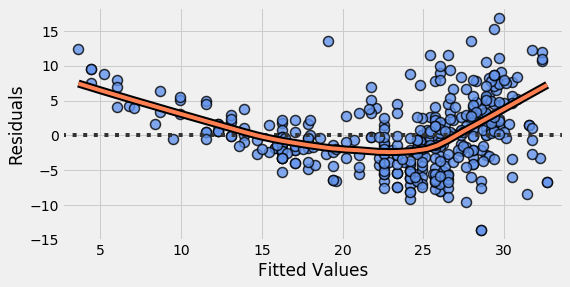

In [42]:
plot_residuals(model_linear)

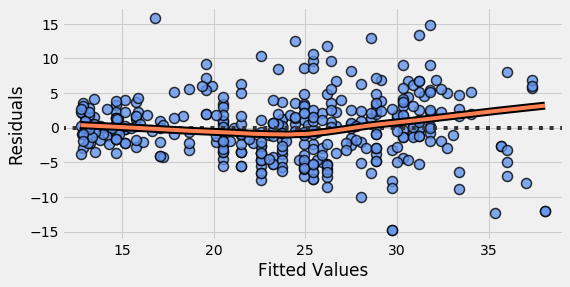

In [43]:
plot_residuals(model_poly)

In generale, se un *residual plot* evidenzia un'associazione non lineare nei dati, l'approccio più semplice è applicare delle trasformazioni non lineari ai predittori, come ad esempio $log(X), \sqrt{X}$ o $X^2$.

---

<a id="correlation-error-terms"></a>
### Correlation of error terms

Un'importante assunzione della regressione lineare è che i singoli *error terms* $\epsilon_1, \epsilon_2,\dots,\epsilon_n$ non siano correlati tra loro, ovvero che la conoscenza di $\epsilon_i$ non fornisce alcuna informazione sul segno o sul valore di $\epsilon_{i+1}$.

La non correlazione degli *error terms* è centrale nel calcolo degli *standard errors* delle stime parametriche, i quali influenzano direttamente la costruzione dei *confidence/prediction intervals* e i risultati dell'*hypothesis testing*.

Se gli *error terms* fossero correlati, gli intervalli sarebbero più stretti e indicherebbero un'ingiustificata maggiore accuratezza delle stime, o i *p-values* sarebbero inferiori, portandoci a concludere che un predittore è significativo quando in realtà non lo è.

Basta considerare cosa accadrebbe se per errore duplicassimo un dataset di dimensione $n$: gli *standard error* sarebbero calcolati sulla base di $2n$ osservazioni, mentre solo $n$ sono i veri campioni; di conseguenza le stime parametriche sarebbero identiche, ma gli intervalli sarebbero più stretti di un fattore pari a $\sqrt{2}$!

La correlazione fra *error terms* si verifica spesso nel contesto delle *time series*, quando le misurazioni sono ottenute in istanti discreti di tempo, portando le osservazioni campionate in *time steps* adiacenti ad avere errori correlati. Più in generale, questo tipo di correlazione può anche verificarsi nel momento in cui gli elementi del *sample* non sono indipendenti tra loro, come nel caso di esperimenti effettuati su un gruppo di persone di cui fa parte un'intera famiglia.

Per identificare questo fenomeno, dobbiamo plottare i residui del modello in funzione del tempo, o dell'ordine naturale di campionamento del dataset. Se gli errori non sono correlati, non dovremmo evidenziare alcun pattern distinguibile; in caso contrario, potremmo notare il cosiddetto **residual tracking**, un pattern per cui residui adiacenti presentano valori simili.

<img src="imgs/error-terms-correlation.PNG"></img>

Il primo plot non mostra alcun pattern nell'andamento dei residui, mentre il secondo è un esempio lampante di *tracking*.

Possiamo mostrare anche un esempio pratico di assenza di *tracking* plottando l'andamento dei residui del modello di regressione lineare _Sales ~ TV + Radio_.

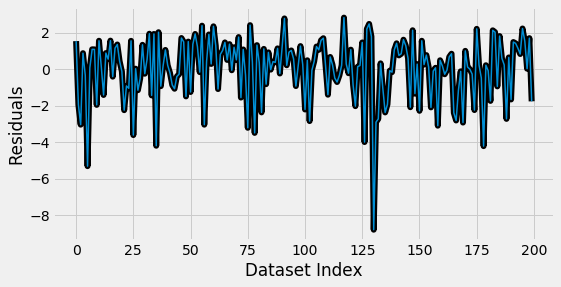

In [44]:
model = smf.ols("Sales ~ TV + Radio", adv).fit()

plot_errors_corr(model)

---

<a id="heteroscedasticity"></a>
### Heteroscedasticity

Un'altra assunzione fondamentale della regressione lineare è che gli *error terms*, oltre a non essere correlati fra loro, devono condividere la stessa varianza: $Var(\epsilon_i)=\sigma^2$. Praticamente tutti i risultati prodotti dal modello sono influenzati da quest'assunzione: gli *standard errors*, gli intervalli e i *p-value*.

Sfortunatamente, nei casi reali, è facile che la varianza degli *error terms* non sia costante; ad esempio, accade spesso che tale varianza aumenti proporzionalmente ai valori della *response*.

L'identificazione dell'**heteroscedasticity** può avvenire tramite l'analisi grafica di un *residual plot*, andando alla ricerca di un'ipotetica **funnel shape**.

<img src="imgs/heteroscedasticity.PNG"></img>

Nell'esempio proposto accade esattamente questo: la magnitudine dei residui tende ad aumentare in proporzione ai valori dei *fitted values*, evidenziando la *funnel shape*.

Una possibile soluzione consiste nel trasformare la *response* attraverso una funzione concava come il logaritmo naturale o la radice quadrata. In questo modo, si otterrà una diminuzione dei valori più alti della *response*, limitando l'entità dell'*heteroscedasticity*.

---

<a id="outliers"></a>
### Outliers & High Leverage points

Un *outlier* è un'osservazione il cui valore di *response* è molto lontano rispetto al valore predetto dal modello.

Rimuovere un *outlier* ha effetti minimi sui *model coefficients*, ma può causare altr problemi. Ad esempio, rimuovendo degli *outlier* potremmo notare sia una diminuzione del *RSE* che un aumento dell'$R^2$. Ricordiamo che il *RSE* è usato per calcolare tutti i *confidence intervals* e i *p-values*, quindi influenza quasi tutti i risultati del modello.

Un metodo rapido per trattare il problema è analizzare il *residual plot* del modello: gli *outlier*, infatti, per definizione generano residui molto più grandi del normale, e saltano subito all'occhio. Il problema è che, all'atto pratico, è difficile capire quanto grande dovrebbe essere un residuo per essere considerato un *outlier*.

Questo dubbio può essere risolto plottando gli **studentized residuals** al posto dei residui classici: si tratta del rapporto fra i singoli residui e i loro *standard error*. Le osservazioni che presentano *studentized residual* superiori a 3 in valore assoluto, sono possibili *outliers*.

Cerchiamo degli *outlier* nel modello *Sales ~ TV + Radio*.

In [45]:
model = smf.ols("Sales ~ TV + Radio", adv).fit()

Filtriamo direttamente le osservazioni con *studentized residuals* superiori a 3 in valore assoluto.

In [46]:
adv["student_resid"] = model.get_influence().resid_studentized_internal
adv[np.abs(adv.student_resid) > 3]

,TV,Radio,Newspaper,Sales,student_resid
5,8.7,48.9,75.0,7.2,-3.215600
130,0.7,39.6,8.7,1.6,-5.303997


Mostriamo graficamente il nuovo tipo di *residual plot*:

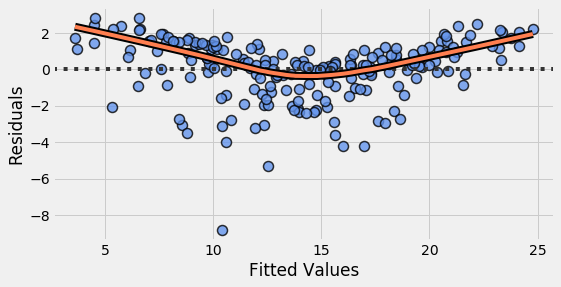

In [47]:
plot_residuals(model)

<br>

Al contrario degli *outlier*, un'osservazione con *high leverage* presenta dei valori inusuali per quanto riguarda i *predictors*, non la *response*.

La rimozione di un *high leverage point* ha un impatto considerevole sui *model coefficients*, di conseguenza individuarli è fondamentale.

Sebbene nella regressione lineare univariata l'individuazione degli *high leverage points* sia molto semplice, nella regressione multivariata non è così: è molto probabile che ci siano delle osservazioni i cui valori dei singoli predittori sono perfettamente all'interno dei range più comuni, ma la cui combinazione totale è particolarmente inusuale.

Per quantificare la *leverage* di un'osservazione, si utilizza la **leverage statistic**. A titolo di esempio, mostriamo la sua formulazione per la regressione lineare univariata.

$$\large h_i=\frac{1}{n}+\frac{(x_i-\bar{x})^2}{\sum_{j=1}^{n}(x_j-\bar{x})^2}$$

La *leverage statistics* è sempre compresa fra $1/n$ e $1$, mentre il valore medio si assesta su $(p+1)/n$. Perciò se un'osservazione presenta una *leverage statistic* che eccede fortemente il valore medio, possiamo ragionevolmente sospettare che si tratti di un *high leverage point*.

Calcoliamo la *leverage* per le osservazioni del modello *Sales ~ TV + Radio*.

In [48]:
model = smf.ols("Sales ~ TV + Radio", adv).fit()

adv["leverage"] = model.get_influence().hat_matrix_diag

Il valore medio della *leverage statistic* è:

In [49]:
p = 2

avg_leverage = (p + 1) / len(adv)
avg_leverage

0.015

Possiamo plottare gli *studentized residuals* in funzione della *leverage statistics* per individuare contemporaneamente *outliers* e *high leverage points*.

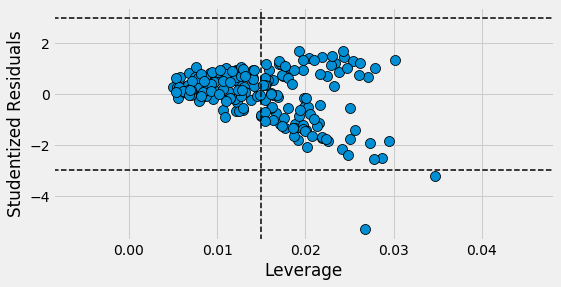

In [50]:
plot_stud_vs_leverage(model, p = 2, n = len(adv))

---

<a id="collinearity"></a>
### Collinearity

La *collinearity* è un fenomeno in cui due o più predittori sono altamente correlati tra di loro. Rappresenta un problema importante nell'applicazione della regressione lineare, poiché se due predittori crescono o decrescono in maniera concorde, può essere difficile determinare in che modo ciascuno di essi sia associato alla *response*.

Facciamo un esempio usando il dataset *Credit*. Mentre i due predittori *limit* ed *age* non mostrano alcuna relazione, *limit* e *rating* sono altamente correlati tra loro, e si dice che sono *collineari*.

Il problema principale è questo: se proviamo ad applicare il *least squares criterion* a due predittori altamente correlati, la combinazione di valori che restituisce il minimo *RSS* (e quindi va a comporre il modello finale) non è facilmente distinguibile dalle altre. In altre parole, ci sono tantissime combinazioni dei valori dei due predittori che restituiscono un *RSS* vicino al valore ottimale, creando così una forte incertezza nella stima parametrica.

Dal punto di vista matematico, la presenza di *collinearity* aumenta l'entità degli *standard error* dei coefficienti $\hat{\beta}_i$, causando così una diminuzione delle *t-statistics* e, di conseguenza, del **power** dell'*hypothesis test*, cioè la probabilità di individuare correttamente un predittore significativo.

Applichiamo la regressione multipla usando prima *Age* e *Limit* e poi *Rating* e *Limit*.

In [51]:
model = smf.ols("Balance ~ Age + Limit", cred).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-173.4109,43.828,-3.957,0.000,-259.576,-87.246
Age,-2.2915,0.672,-3.407,0.001,-3.614,-0.969
Limit,0.1734,0.005,34.496,0.000,0.163,0.183


In [52]:
model = smf.ols("Balance ~ Rating + Limit", cred).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-377.5368,45.254,-8.343,0.000,-466.505,-288.569
Rating,2.2017,0.952,2.312,0.021,0.330,4.074
Limit,0.0245,0.064,0.384,0.701,-0.101,0.150


Nel primo caso abbiamo due predittori altamente significativi, mentre nel secondo la *collinearity* ha incrementato fortemente lo *standard error* di *Limit*, portando ad un *p-value* non significativo. In altre parole, l'importanza di *Limit* nella previsione di *Balance* è stata del tutto mascherata dalla *collinearity*.

Uno dei metodi più immediati per verificare la presenza di *collinearity* consiste nella costruzione della *correlation matrix*. Purtroppo, però, è possibile che ci sia *collinearity* fra tre o più variabili anche se nessuna delle coppie in questione presenti alta correlazione nella matrice. Situazioni del genere definiscono il fenomeno della **multicollinearity**.

In questi casi, è meglio calcolare il cosiddetto **Variance Inflation Factor**: si tratta del rapporto fra la variabilità totale del modello originale e la variabilità del modello che include solo il predittore del quale si vuole calcolare il *VIF*.

Il valore più piccolo possibile per il *VIF* è 1, che indica assenza totale di *collinearity*. Ricordiamo che, all'atto pratico, una debole presenza di *collinearity* fra predittori è sempre attesa. Se, invece, il *VIF* di alcuni predittori supera 5 o 10, allora possiamo concludere che tali variabili sono altamente correlate con le altre.

Presentiamo di seguito la formulazione del *VIF*:

$$\large VIF(\hat{\beta}_i)=\frac{1}{1-R^2_{X_i|X_{-i}}}$$

Il parametro $R^2_{X_i|X_{-i}}$ è l'$R^2$ calcolato per una regressione che prova a modellare $X_i$ a partire da tutti gli altri predittori. Se il valore di questo $R^2$ è vicino a uno, allora la *collinearity* è presente, e quindi il *VIF* sarà molto alto.

Nel dataset *Credit*, ad esempio, se calcoliamo il *VIF* per i tre predittori *age*, *rating* e *limit*, troviamo valori come $1.01, 160.67, 160.59$, a testimonianza della presenza di *collinearity* nei dati!

In [53]:
model_age = smf.ols("Age ~ Rating + Limit", cred).fit()
model_rating = smf.ols("Rating ~ Age + Limit", cred).fit()
model_limit = smf.ols("Limit ~ Age + Rating", cred).fit()

vif_age = 1 / (1 - model_age.rsquared)
vif_rating = 1 / (1 - model_rating.rsquared)
vif_limit = 1 / (1 - model_limit.rsquared)

vif_age, vif_rating, vif_limit

(1.0113846860681328, 160.66830095856935, 160.59287978597942)

Un esempio applicativo più generalizzato del *VIF* sul dataset *Credit*:

In [54]:
df = cred[["Balance", "Age", "Rating", "Limit"]]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(exog = df.values , exog_idx = i)
              for i in range(df.shape[1])]
vif["Predictors"] = df.columns
vif

,VIF,Predictors
0,8.785017,Balance
1,8.479106,Age
2,612.939729,Rating
3,559.074704,Limit


Eliminiamo *Rating* e notiamo come varia il *VIF*:

In [55]:
df = cred[["Balance", "Age", "Limit"]]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(exog = df.values , exog_idx = i)
              for i in range(df.shape[1])]
vif["Predictors"] = df.columns
vif

,VIF,Predictors
0,8.777989,Balance
1,5.381954,Age
2,17.828013,Limit


Facciamo lo stesso con *Limit*:

In [56]:
df = cred[["Balance", "Age", "Rating"]]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(exog = df.values , exog_idx = i)
              for i in range(df.shape[1])]
vif["Predictors"] = df.columns
vif

,VIF,Predictors
0,8.487425,Balance
1,6.502695,Age
2,19.545684,Rating


Combiniamo le due variabili altamente correlate e notiamo come reagisce il *VIF*!

In [57]:
df = cred[["Balance", "Age", "Rating", "Limit"]].copy()
df["RatingLimit"] = df.Rating * df.Limit
df.drop(["Rating", "Limit"], axis = 1, inplace = True)

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(exog = df.values , exog_idx = i)
              for i in range(df.shape[1])]
vif["Predictors"] = df.columns
vif

,VIF,Predictors
0,6.182466,Balance
1,2.168385,Age
2,6.223705,RatingLimit


---

<a id="comparison"></a>
# Comparison of Linear Regression with KNN

Uno dei *non-parametric learnig method* più semplici e famosi è il **K-Nearest Neighbors Regressor**.

Dato un intero $K$ e un'osservazione di test $x_0$, il *KNN* identifica le $K$ osservazioni di *training* più vicine a $x_0$ e produce una stima di $f(x_0)$ calcolando la media di tutte le *responses* dei *neighbors* di $x_0$.

$$\large \hat{f}(x_0)=\frac{1}{K}\sum_{x_i\in N_0}y_i$$

Il valore ottimale di $K$ dipende, come sempre, dal *bias-variance trade-off*: valori piccoli di $K$ portano a modelli estremamente flessibili, caratterizzati da *low bias* e *high variance* (dato che le *prediction* in una certa regione dipendono solo da una o poche osservazioni); al contrario, per grandi valori di $K$, si osservano modelli meno variabili e dall'andamento più morbido, che rischiano di introdurre del *bias* nell'approssimazione di una funzione complessa come $f$.

I metodi parametrici come la regressione lineare si comportano sempre meglio rispetto ai non-parametrici nel momento in cui l'assunzione parametrica di fondo rispetta l'andamento reale della *systematic information*.

Ad esempio, se $f$ è realmente una retta univariata, è quasi impossibile che il *KNN* possa battere la regressione lineare. Solo per altissimi valori di $K$ avremo un *test MSE* leggermente superiore a quello della regressione lineare, ma per $K$ più alti la differenza è enorme.

Nella realtà, purtroppo, è quasi impossibile che la *systematic information* sia perfettamente lineare. Già con un andamento leggermente non lineare, si nota come la regressione lineare sia superiore solo per bassi valori di $K$, dove il *KNN* presenta delle *prediction* troppo caotiche, mentre per $K$ superiori a una certa soglia (4 o 5) è quest'ultimo a fornire il *test MSE* più basso.

Si potrebbe pensare di utilizzare sempre il *KNN*, dato che se $f$ è lineare si avranno al massimo delle performance leggermente inferiori rispetto alla regressione lineare, mentre se $f$ è non lineare otterremmo un modello più performante.

In verità, oltre al grado di non linearità della *systematic information*, un altro parametro da tenere in considerazione nel confronto *parametric/non-parametric* è il numero di predittori.

Se $p=1$ o $p=2$, il *KNN* si comporta meglio della regressione lineare (per $f$ non lineari), mentre per $p=3$ o $p=4$ già otteniamo dei risultati confrontabili o totalmente a favore della regressione lineare.

Questa decrescita del *test MSE* in corrispondenza di un aumento di dimensionalità è un problema comune per il *KNN*, e per i metodi non-parametrici in generale. 

Se per un dataset di cardinalità 100 abbiamo $p=1$, dovremmo avere abbastanza informazioni per stimare $f$ adeguatamente; se invece abbiamo $p=20$, la costruzione dei *neighbors* coinvolgerà osservazioni che in realtà sono molto distanti fra loro, se considerate all'interno di uno spazio p-dimensionale.

In generale, i metodi parametrici tendono a fornire prestazioni migliori dei non-parametrici quando il numero di osservazioni per predittore è molto basso.

---

<a id="lab"></a>
# Lab

**Addestrare una regressione lineare univariata usando *mpg* come *response* e *horsepower* come predittore.**

In [58]:
model = smf.ols("mpg ~ horsepower", auto).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,39.9359,0.717,55.660,0.000,38.525,41.347
horsepower,-0.1578,0.006,-24.489,0.000,-0.171,-0.145


Il predittore è significativo; per ogni aumento unitario di *horsepower* abbiamo un decremento di *mpg* pari a -0.16. La relazione fra *response* e *predictor*, quindi, è negativa.

<br>

**Quanto è forte la relazione fra mpg e horsepower?**

Calcoliamo innanzitutto il RSE:

In [59]:
rse = np.sqrt(model.ssr / model.df_resid)
rse

4.90575691954594

Il percentage error è quasi del 21%!

In [60]:
rse / np.mean(auto.mpg)

0.2092371406691483

L'R-squared è circa 0.6, cioè circa il 60% della varianza di mpg è spiegata da horsepower.

In [61]:
model.rsquared

0.6059482578894348

<br>

**Calcolare il valore di mpg predetto per un'auto con horsepower pari a 98. Costruiamo anche i 95% CI e PI.**

In [62]:
x_test = pd.DataFrame({"horsepower": [98]})

In [63]:
get_interval(model, x_test, method = "confidence")

,mean_pred,conf_int_lower,conf_int_upper
0,24.467077,23.973079,24.961075


In [64]:
get_interval(model, x_test, method = "prediction")

,mean_pred,pred_int_lower,pred_int_upper
0,24.467077,14.809396,34.124758


<br>

**Plottare la least squares regression line**

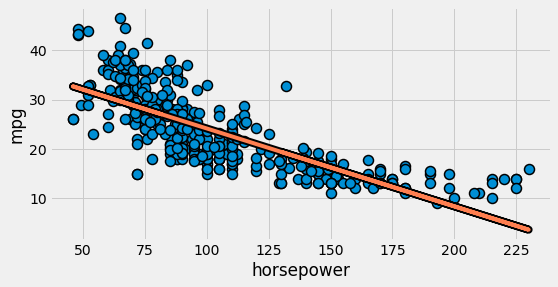

In [65]:
fig, ax = plt.subplots(figsize = (8, 4))
line_edge = [mpe.Stroke(linewidth = 8, foreground= "k"), mpe.Normal()]
sns.scatterplot(data = auto, x = "horsepower", y = "mpg", ax = ax,
                s = 100, linewidth = 1.5, edgecolor = "k")
plt.plot(auto.horsepower, model.predict(auto.horsepower),
         color = "coral", path_effects = line_edge)
plt.show()

<br>

**Plottare i Diagnostics Plots**

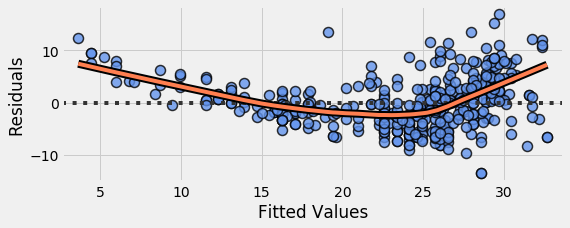

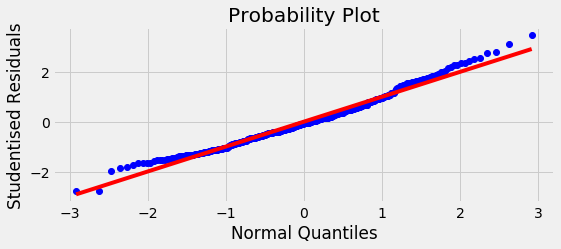

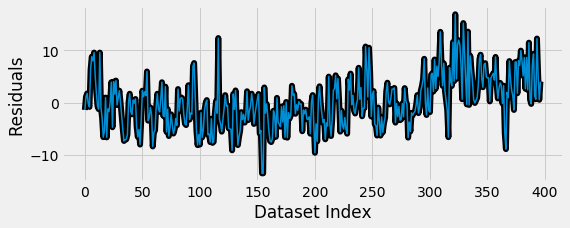

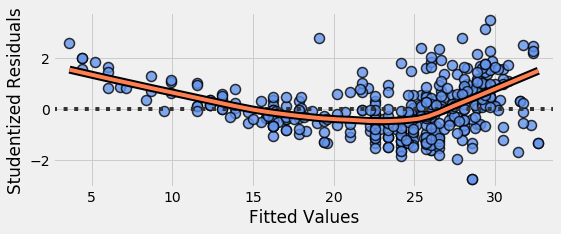

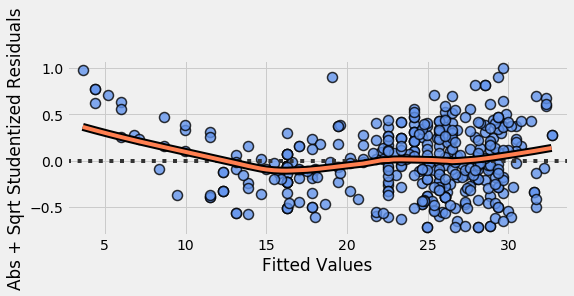

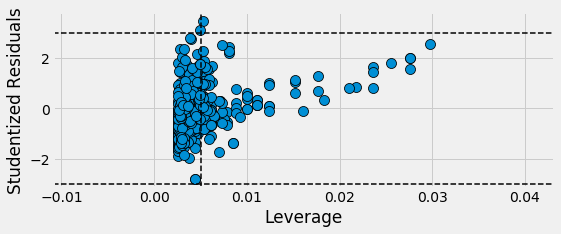

In [66]:
diagnostics_plots(model, p = 1, n = len(auto), figsize = (8, 3))

C'è un pattern evidente nei residui, che indica non linearità nella relazione predictor-response.

Sembra essere presente anche l'heteroscedasticity, ma potremmo essere in grado di correggerla con un fit quadratico, oppure trasformando la response con il logaritmo o la radice quadrata.

Notiamo anche qualche osservazione sopra il valore 3 per gli studentized residuals (possibili outliers) e diverse osservazioni ad alta leverage.

<br>

**Utilizzare tutti i predittori possibili, escluso il nome dell'auto che non ha alcun valore predittivo.**

Modifichiamo origin che al momento è nella forma 1, 2, 3 e verrebbe modellato come una variabile ordinale.

In [67]:
auto["origin"].replace({1: "American", 2: "European", 3: "Japanese"},
                       inplace = True)
auto["origin"].value_counts()

American    245
Japanese     79
European     68
Name: origin, dtype: int64

Addestriamo la regressione multipla:

In [68]:
model = smf.ols("""mpg ~ cylinders + displacement + horsepower + 
                weight + acceleration + year + origin""", auto).fit()

L'*F-test* riporta un *p-value* praticamente nullo, quindi c'è sicuramente una relazione fra *predictors* e *response*.

In [69]:
model.summary().tables[0]

Dep. Variable:,mpg,R-squared:,0.824
Model:,OLS,Adj. R-squared:,0.821
Method:,Least Squares,F-statistic:,224.5
Date:,"Sun, 21 Feb 2021",Prob (F-statistic):,1.79e-139
Time:,08:49:42,Log-Likelihood:,-1020.5
No. Observations:,392,AIC:,2059.
Df Residuals:,383,BIC:,2095.
Df Model:,8,,
Covariance Type:,nonrobust,,


Gli unici predittori che non sembrano essere significativi nella previsione di *mpg* sono *cylinders*, *horsepower* e *acceleration*.

In [70]:
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-17.9546,4.677,-3.839,0.000,-27.150,-8.759
origin[T.European],2.6300,0.566,4.643,0.000,1.516,3.744
origin[T.Japanese],2.8532,0.553,5.162,0.000,1.766,3.940
cylinders,-0.4897,0.321,-1.524,0.128,-1.121,0.142
displacement,0.0240,0.008,3.133,0.002,0.009,0.039
horsepower,-0.0182,0.014,-1.326,0.185,-0.045,0.009
weight,-0.0067,0.001,-10.243,0.000,-0.008,-0.005
acceleration,0.0791,0.098,0.805,0.421,-0.114,0.272
year,0.7770,0.052,15.005,0.000,0.675,0.879


<br>

**Plottare i Diagnostics Plots**

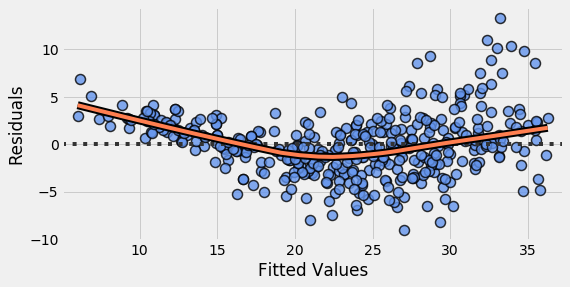

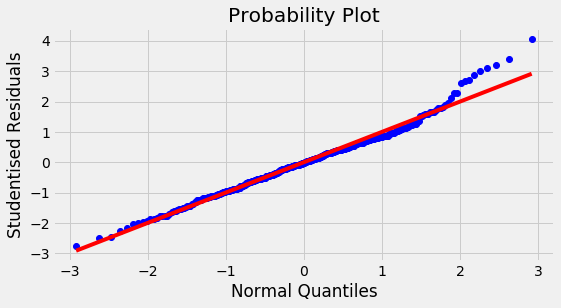

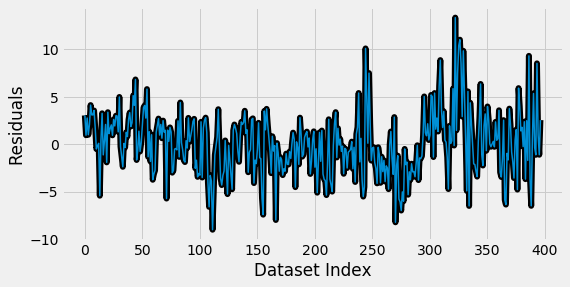

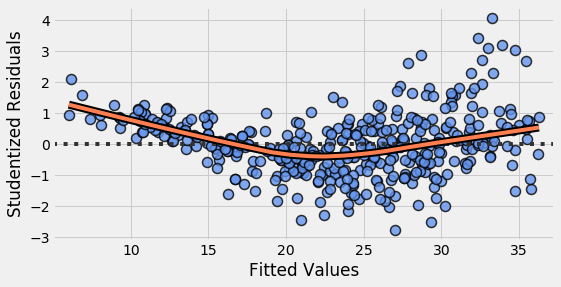

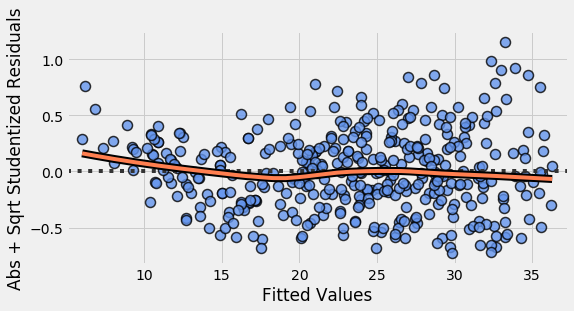

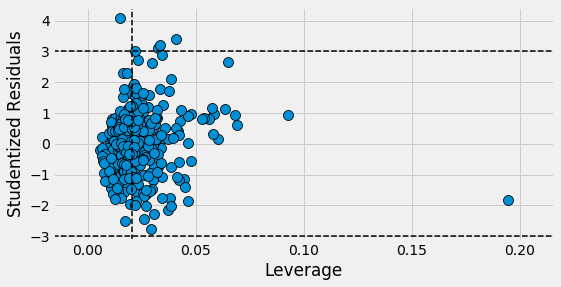

In [71]:
diagnostics_plots(model = model, p = 7, n = len(auto))

La *U-Shape* dei residui è meno pronunciata, l'*heteroscedasticity* sembra essere ancora presente.

Si notano delle osservazioni ad alta *leverage* e dei possibili outliers oltre la soglia di +3-3 per gli studenzied.

**Applicare gli interaction terms per cercare relazioni sinergiche utili**

In [72]:
interactions = parse_interactions(auto.columns, bad_vars = ["name", "mpg"])

In [73]:
model = smf.ols(f"mpg ~ {interactions}", auto).fit()
summary = pd.read_html(model.summary().tables[1].as_html(),
                       header = 0, index_col = 0)[0]
summary.sort_values(by = "P>|t|", inplace = True)
significant = summary[summary["P>|t|"] <= 0.05]
significant

,coef,std err,t,P>|t|,[0.025,0.975]
acceleration:origin[T.European],0.885300,0.30500,2.904,0.004,0.286000,1.485
horsepower:year,-0.030200,0.01200,-2.591,0.010,-0.053000,-0.007
horsepower,2.734400,1.06400,2.570,0.011,0.642000,4.827
year,1.959100,0.87200,2.246,0.025,0.243000,3.675
acceleration:origin[T.Japanese],0.743900,0.33600,2.216,0.027,0.084000,1.404
horsepower2,-0.010900,0.00500,-2.198,0.029,-0.021000,-0.001
cylinders:acceleration,0.411800,0.19400,2.126,0.034,0.031000,0.793
year:horsepower2,0.000085,0.00004,2.116,0.035,0.000006,0.000


Dovremmo usare una soglia più bassa per idetificare le interazioni significative, dato l'alto numero di predittori.

In ogni caso, evidenziamo le seguenti interazioni significative:
- *acceleration:origin*
- *acceleration:year*
- *cylinders:acceleration*
- *year:origin*

<br>

**Applicare delle trasformazioni ai predittori e verificarne l'impatto sulla qualità del modello.**

Partiamo dal modello di base:

In [74]:
model = smf.ols(f"""mpg ~ displacement + weight + year + origin
                + acceleration*origin + acceleration*year
                + cylinders*acceleration + year*origin""", auto).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,84.9283,23.263,3.651,0.000,39.187,130.669
origin[T.European],-36.4457,10.273,-3.548,0.000,-56.646,-16.246
origin[T.Japanese],-40.4281,9.692,-4.171,0.000,-59.485,-21.371
displacement,-0.0002,0.007,-0.028,0.978,-0.015,0.015
weight,-0.0059,0.001,-10.395,0.000,-0.007,-0.005
year,-0.3674,0.278,-1.320,0.188,-0.915,0.180
year:origin[T.European],0.2733,0.132,2.066,0.040,0.013,0.533
year:origin[T.Japanese],0.3225,0.114,2.837,0.005,0.099,0.546
acceleration,-5.8326,1.465,-3.982,0.000,-8.712,-2.953
acceleration:origin[T.European],1.0459,0.191,5.467,0.000,0.670,1.422


In [75]:
model.rsquared_adj

0.8496393766053771

Applicando il logaritmo ai predittori quantitativi miglioriamo l'Adjusted R-Squared!

In [76]:
model = smf.ols(f"""mpg ~ np.log(displacement) + np.log(weight)
                + np.log(year) + origin + acceleration*origin + acceleration*year
                + cylinders*acceleration + year*origin""", auto).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1995.8128,487.111,4.097,0.000,1038.017,2953.608
origin[T.European],-38.5160,9.393,-4.100,0.000,-56.986,-20.046
origin[T.Japanese],-34.1718,8.913,-3.834,0.000,-51.697,-16.647
np.log(displacement),-2.9375,1.357,-2.164,0.031,-5.606,-0.269
np.log(weight),-16.9046,1.662,-10.173,0.000,-20.172,-13.637
np.log(year),-537.1607,148.882,-3.608,0.000,-829.904,-244.418
acceleration,-5.5370,1.404,-3.945,0.000,-8.297,-2.777
acceleration:origin[T.European],0.9781,0.175,5.580,0.000,0.633,1.323
acceleration:origin[T.Japanese],0.8483,0.210,4.031,0.000,0.435,1.262
year,6.8081,2.069,3.291,0.001,2.740,10.876


In [77]:
model.rsquared_adj

0.8763577761572058

Migliorano parzialmente anche i diagnostics plots: sembra esserci meno non-linearità nei residui.

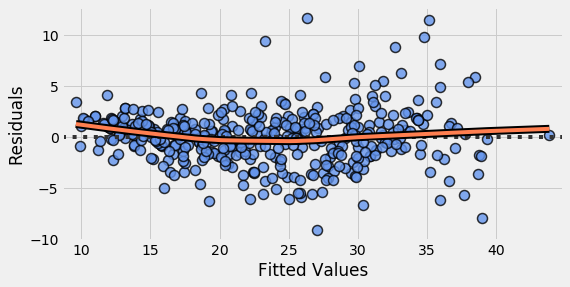

In [78]:
plot_residuals(model)

Applicando il quadrato, invece, l'Adjusted R-squared diminuisce. Andrebbe trovata la migliore combinazione!

In [79]:
model = smf.ols(f"""mpg ~ np.power(displacement,2)
                + np.power(weight, 2) + np.power(year, 2)
                + origin + acceleration*origin + acceleration*year
                + cylinders*acceleration + year*origin""", auto).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,347.0806,81.937,4.236,0.000,185.970,508.191
origin[T.European],-42.5694,10.928,-3.895,0.000,-64.058,-21.081
origin[T.Japanese],-39.6460,10.290,-3.853,0.000,-59.879,-19.413
"np.power(displacement, 2)",2.643e-05,1.29e-05,2.056,0.040,1.16e-06,5.17e-05
"np.power(weight, 2)",-7.834e-07,8.62e-08,-9.088,0.000,-9.53e-07,-6.14e-07
"np.power(year, 2)",0.0562,0.015,3.746,0.000,0.027,0.086
acceleration,-2.3522,1.632,-1.442,0.150,-5.560,0.856
acceleration:origin[T.European],0.9411,0.205,4.599,0.000,0.539,1.343
acceleration:origin[T.Japanese],1.3445,0.241,5.571,0.000,0.870,1.819
year,-8.1870,2.198,-3.725,0.000,-12.509,-3.865


In [80]:
model.rsquared_adj

0.8310914179795266

<br>

Otteniamo quasi 90% di R-Squared con la seguente combinazione, sfruttando logaritmi, potenze e interazioni!

In [81]:
model = smf.ols(f"""np.log(mpg) ~ np.power(displacement,2)
                + np.power(horsepower, 2)
                + np.log(weight)
                + origin
                + acceleration*origin
                + acceleration*year
                + cylinders*acceleration
                + year*origin""", auto).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.1044,0.937,11.846,0.000,9.261,12.948
origin[T.European],-0.4589,0.366,-1.253,0.211,-1.179,0.261
origin[T.Japanese],-0.4597,0.346,-1.330,0.184,-1.139,0.220
"np.power(displacement, 2)",7.561e-07,4.35e-07,1.737,0.083,-1e-07,1.61e-06
"np.power(horsepower, 2)",-5.465e-06,1.6e-06,-3.416,0.001,-8.61e-06,-2.32e-06
np.log(weight),-0.7810,0.054,-14.586,0.000,-0.886,-0.676
acceleration,-0.2526,0.052,-4.836,0.000,-0.355,-0.150
acceleration:origin[T.European],0.0341,0.007,4.989,0.000,0.021,0.048
acceleration:origin[T.Japanese],0.0208,0.008,2.504,0.013,0.004,0.037
year,-0.0140,0.010,-1.416,0.158,-0.034,0.005


In [82]:
model.rsquared_adj

0.8994181152954376

---